<a href="https://colab.research.google.com/github/Jushef/Stock-Market-Analysis/blob/main/SP500%26BTC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Limpieza de datos

## Sobre los datos
En este cuaderno, utilizaremos los datos de temperatura diaria de la API de los [Centros Nacionales de Información Ambiental (NCEI)](https://www.ncdc.noaa.gov/cdo-web/webservices/v2). Utilizaremos el conjunto de datos de la Red Global de Climatología Histórica - Diaria (GHCND); véase la documentación [aquí](https://www1.ncdc.noaa.gov/pub/data/cdo/documentation/GHCND_documentation.pdf).

Estos datos se recogieron en la estación del aeropuerto de LaGuardia en la ciudad de Nueva York para octubre de 2018. Contiene:
- la temperatura mínima diaria (`TMIN`)
- la temperatura máxima diaria (`TMAX`)
- la temperatura media diaria (`TAVG`)

*Nota: El NCEI forma parte de la Administración Nacional Oceánica y Atmosférica (NOAA) y, como puede ver en la URL de la API, este recurso se creó cuando el NCEI se llamaba NCDC. Si la URL de este recurso cambia en el futuro, puede buscar "NCEI weather API" para encontrar la actualizada.*

Además, utilizaremos datos del mercado bursátil S&P 500 y datos de bitcoin para los años 2020 a 2022. Los datos de bitcoin se recogieron de CoinMarketCap utilizando el paquete `stock_analysis`; sin embargo, los cambios en el sitio web hicieron necesario cambiar la fuente de datos a Yahoo! Finance. Los datos de bitcoin que se recogieron antes del cambio de sitio web de CoinMarketCap deberían ser equivalentes a los datos históricos que se pueden ver en [esta](https://coinmarketcap.com/currencies/bitcoin/historical-data/).

## Configuración
Necesitamos importar `pandas` y leer los datos de temperatura para empezar:


In [1]:
import pandas as pd

df = pd.read_csv('/content/nyc_temperatures.csv')
df.head()

,date,datatype,station,attributes,value
0,2018-10-01T00:00:00,TAVG,GHCND:USW00014732,"H,,S,",21.2
1,2018-10-01T00:00:00,TMAX,GHCND:USW00014732,",,W,2400",25.6
2,2018-10-01T00:00:00,TMIN,GHCND:USW00014732,",,W,2400",18.3
3,2018-10-02T00:00:00,TAVG,GHCND:USW00014732,"H,,S,",22.7
4,2018-10-02T00:00:00,TMAX,GHCND:USW00014732,",,W,2400",26.1


## Cambiar el nombre de las columnas
Comenzamos con las siguientes columnas:

In [2]:
df.columns

Index(['date', 'datatype', 'station', 'attributes', 'value'], dtype='object')

Queremos renombrar la columna `value` para indicar que contiene la temperatura en Celsius y la columna `attributes` para decir `flags` ya que cada valor en la cadena delimitada por comas es una bandera diferente sobre la colección de datos. Para esta tarea, utilizamos el método `rename()` y pasamos un diccionario que asigna los nombres de las columnas a sus nuevos nombres. Pasamos `inplace=True` para cambiar nuestro marco de datos original en lugar de obtener uno nuevo:

In [3]:
df.rename(
    columns={
        'value': 'temp_C',
        'attributes': 'flags'
    }, inplace=True
)

Esas columnas han sido renombradas con éxito:

In [4]:
df.columns

Index(['date', 'datatype', 'station', 'flags', 'temp_C'], dtype='object')

También podemos realizar operaciones de cadena en los nombres de las columnas con `rename()`:

In [5]:
df.rename(str.upper, axis='columns').columns

Index(['DATE', 'DATATYPE', 'STATION', 'FLAGS', 'TEMP_C'], dtype='object')

## Conversión de tipos
La columna `date` no se almacena actualmente como una `datetime`:

In [6]:
df.dtypes

date         object
datatype     object
station      object
flags        object
temp_C      float64
dtype: object

Realicemos la conversión con `pd.to_datetime()`:

In [7]:
df.loc[:,'date'] = pd.to_datetime(df.date)
df.dtypes

date        datetime64[ns]
datatype            object
station             object
flags               object
temp_C             float64
dtype: object

Ahora obtenemos información útil cuando utilizamos `describe()` en esta columna:

In [8]:
df.date.describe(datetime_is_numeric=True)

count                     93
mean     2018-10-16 00:00:00
min      2018-10-01 00:00:00
25%      2018-10-08 00:00:00
50%      2018-10-16 00:00:00
75%      2018-10-24 00:00:00
max      2018-10-31 00:00:00
Name: date, dtype: object

Podemos utilizar `tz_localize()` en un objeto `DatetimeIndex` para convertirlo a la zona horaria deseada:

In [9]:
pd.date_range(start='2018-10-25', periods=2, freq='D').tz_localize('EST')

DatetimeIndex(['2018-10-25 00:00:00-05:00', '2018-10-26 00:00:00-05:00'], dtype='datetime64[ns, EST]', freq=None)

Esto también funciona con objetos `Series`/`DataFrame` que tienen un índice de tipo `DatetimeIndex`. Volvamos a leer el CSV para este ejemplo y establezcamos que la columna `date` sea el índice y se almacene como datetime:

In [11]:
eastern = pd.read_csv(
    '/content/nyc_temperatures.csv', index_col='date', parse_dates=True
).tz_localize('EST')

eastern.head()

,datatype,station,attributes,value
date,,,,
2018-10-01 00:00:00-05:00,TAVG,GHCND:USW00014732,"H,,S,",21.2
2018-10-01 00:00:00-05:00,TMAX,GHCND:USW00014732,",,W,2400",25.6
2018-10-01 00:00:00-05:00,TMIN,GHCND:USW00014732,",,W,2400",18.3
2018-10-02 00:00:00-05:00,TAVG,GHCND:USW00014732,"H,,S,",22.7
2018-10-02 00:00:00-05:00,TMAX,GHCND:USW00014732,",,W,2400",26.1


Podemos usar `tz_convert()` para convertir a otra zona horaria desde allí. Si convertimos las fechas del Este a UTC, ahora estarán a las 5 AM, ya que `pandas` utilizará los desfases para convertir:

In [12]:
eastern.tz_convert('UTC').head()

,datatype,station,attributes,value
date,,,,
2018-10-01 05:00:00+00:00,TAVG,GHCND:USW00014732,"H,,S,",21.2
2018-10-01 05:00:00+00:00,TMAX,GHCND:USW00014732,",,W,2400",25.6
2018-10-01 05:00:00+00:00,TMIN,GHCND:USW00014732,",,W,2400",18.3
2018-10-02 05:00:00+00:00,TAVG,GHCND:USW00014732,"H,,S,",22.7
2018-10-02 05:00:00+00:00,TMAX,GHCND:USW00014732,",,W,2400",26.1


También podemos cambiar el periodo del índice. Podemos cambiar el periodo para que sea mensual y así facilitar la agregación posterior.

In [13]:
eastern.tz_localize(None).to_period('M').index

PeriodIndex(['2018-10', '2018-10', '2018-10', '2018-10', '2018-10', '2018-10',
             '2018-10', '2018-10', '2018-10', '2018-10', '2018-10', '2018-10',
             '2018-10', '2018-10', '2018-10', '2018-10', '2018-10', '2018-10',
             '2018-10', '2018-10', '2018-10', '2018-10', '2018-10', '2018-10',
             '2018-10', '2018-10', '2018-10', '2018-10', '2018-10', '2018-10',
             '2018-10', '2018-10', '2018-10', '2018-10', '2018-10', '2018-10',
             '2018-10', '2018-10', '2018-10', '2018-10', '2018-10', '2018-10',
             '2018-10', '2018-10', '2018-10', '2018-10', '2018-10', '2018-10',
             '2018-10', '2018-10', '2018-10', '2018-10', '2018-10', '2018-10',
             '2018-10', '2018-10', '2018-10', '2018-10', '2018-10', '2018-10',
             '2018-10', '2018-10', '2018-10', '2018-10', '2018-10', '2018-10',
             '2018-10', '2018-10', '2018-10', '2018-10', '2018-10', '2018-10',
             '2018-10', '2018-10', '2018-10', '2018-

Ahora obtenemos un objeto `PeriodIndex`, que podemos volver a convertir en un objeto DatetimeIndex con `to_timestamp()`:

In [14]:
eastern.tz_localize(None).to_period('M').to_timestamp().index

DatetimeIndex(['2018-10-01', '2018-10-01', '2018-10-01', '2018-10-01',
               '2018-10-01', '2018-10-01', '2018-10-01', '2018-10-01',
               '2018-10-01', '2018-10-01', '2018-10-01', '2018-10-01',
               '2018-10-01', '2018-10-01', '2018-10-01', '2018-10-01',
               '2018-10-01', '2018-10-01', '2018-10-01', '2018-10-01',
               '2018-10-01', '2018-10-01', '2018-10-01', '2018-10-01',
               '2018-10-01', '2018-10-01', '2018-10-01', '2018-10-01',
               '2018-10-01', '2018-10-01', '2018-10-01', '2018-10-01',
               '2018-10-01', '2018-10-01', '2018-10-01', '2018-10-01',
               '2018-10-01', '2018-10-01', '2018-10-01', '2018-10-01',
               '2018-10-01', '2018-10-01', '2018-10-01', '2018-10-01',
               '2018-10-01', '2018-10-01', '2018-10-01', '2018-10-01',
               '2018-10-01', '2018-10-01', '2018-10-01', '2018-10-01',
               '2018-10-01', '2018-10-01', '2018-10-01', '2018-10-01',
      

Podemos utilizar el método `assign()` para trabajar con varias columnas a la vez (o crear otras nuevas). Como nuestra columna `date` ya ha sido convertida, necesitamos leer los datos de nuevo:

In [16]:
df = pd.read_csv('/content/nyc_temperatures.csv').rename(
    columns={
        'value': 'temp_C',
        'attributes': 'flags'
    }
)

new_df = df.assign(
    date=pd.to_datetime(df.date),
    temp_F=(df.temp_C * 9/5) + 32
)
new_df.dtypes

date        datetime64[ns]
datatype            object
station             object
flags               object
temp_C             float64
temp_F             float64
dtype: object

La columna `date` tiene ahora fechas y se ha añadido la columna `temp_F`:

In [ ]:
new_df.head()

,date,datatype,station,flags,temp_C,temp_F
0,2018-10-01,TAVG,GHCND:USW00014732,"H,,S,",21.2,70.16
1,2018-10-01,TMAX,GHCND:USW00014732,",,W,2400",25.6,78.08
2,2018-10-01,TMIN,GHCND:USW00014732,",,W,2400",18.3,64.94
3,2018-10-02,TAVG,GHCND:USW00014732,"H,,S,",22.7,72.86
4,2018-10-02,TMAX,GHCND:USW00014732,",,W,2400",26.1,78.98


También podemos utilizar `astype()` para realizar conversiones. Vamos a crear columnas de la parte entera de las temperaturas en Celsius y Fahrenheit. Utilizaremos **funciones lambda**, de forma que podamos utilizar los valores que se crean en la columna `temp_F` para calcular la columna `temp_F_whole`. Es muy común (y útil) utilizar funciones lambda con `assign()`:

In [17]:
df = df.assign(
    date=lambda x: pd.to_datetime(x.date),
    temp_C_whole=lambda x: x.temp_C.astype('int'),
    temp_F=lambda x: (x.temp_C * 9/5) + 32,
    temp_F_whole=lambda x: x.temp_F.astype('int')
)

df.head()

,date,datatype,station,flags,temp_C,temp_C_whole,temp_F,temp_F_whole
0,2018-10-01,TAVG,GHCND:USW00014732,"H,,S,",21.2,21,70.16,70
1,2018-10-01,TMAX,GHCND:USW00014732,",,W,2400",25.6,25,78.08,78
2,2018-10-01,TMIN,GHCND:USW00014732,",,W,2400",18.3,18,64.94,64
3,2018-10-02,TAVG,GHCND:USW00014732,"H,,S,",22.7,22,72.86,72
4,2018-10-02,TMAX,GHCND:USW00014732,",,W,2400",26.1,26,78.98,78


Creación de categorías:

In [18]:
df_with_categories = df.assign(
    station=df.station.astype('category'),
    datatype=df.datatype.astype('category')
)
df_with_categories.dtypes

date            datetime64[ns]
datatype              category
station               category
flags                   object
temp_C                 float64
temp_C_whole             int64
temp_F                 float64
temp_F_whole             int64
dtype: object

In [19]:
df_with_categories.describe(include='category')

,datatype,station
count,93,93
unique,3,1
top,TAVG,GHCND:USW00014732
freq,31,93


Nuestras categorías no tienen orden, pero esto es algo que soporta `pandas`:

In [20]:
pd.Categorical(
    ['med', 'med', 'low', 'high'], 
    categories=['low', 'med', 'high'],
    ordered=True
)

['med', 'med', 'low', 'high']
Categories (3, object): ['low' < 'med' < 'high']

## Reordenación, reindexación y ordenación
Digamos que queremos encontrar los días que alcanzaron las temperaturas más altas en los datos meteorológicos; podemos ordenar nuestros valores por la columna `temp_C` con la mayor en la parte superior para encontrar esto: 

In [21]:
df[df.datatype == 'TMAX'].sort_values(by='temp_C', ascending=False).head(10)

,date,datatype,station,flags,temp_C,temp_C_whole,temp_F,temp_F_whole
19,2018-10-07,TMAX,GHCND:USW00014732,",,W,2400",27.8,27,82.04,82
28,2018-10-10,TMAX,GHCND:USW00014732,",,W,2400",27.8,27,82.04,82
31,2018-10-11,TMAX,GHCND:USW00014732,",,W,2400",26.7,26,80.06,80
10,2018-10-04,TMAX,GHCND:USW00014732,",,W,2400",26.1,26,78.98,78
4,2018-10-02,TMAX,GHCND:USW00014732,",,W,2400",26.1,26,78.98,78
1,2018-10-01,TMAX,GHCND:USW00014732,",,W,2400",25.6,25,78.08,78
25,2018-10-09,TMAX,GHCND:USW00014732,",,W,2400",25.6,25,78.08,78
7,2018-10-03,TMAX,GHCND:USW00014732,",,W,2400",25.0,25,77.00,77
13,2018-10-05,TMAX,GHCND:USW00014732,",,W,2400",22.8,22,73.04,73
22,2018-10-08,TMAX,GHCND:USW00014732,",,W,2400",22.8,22,73.04,73


Sin embargo, esto no es perfecto porque tenemos algunos empates, y no están ordenados de forma consistente. En el primer empate entre el 7º y el 10º, la fecha más temprana va primero, pero lo contrario ocurre con el empate entre el 4º y el 2º. Podemos utilizar otras columnas para deshacer los empates y especificar cómo ordenar cada una con "ascendente". Rompamos los empates con la columna de la fecha y mostremos las fechas anteriores antes que las posteriores:

In [22]:
df[df.datatype == 'TMAX'].sort_values(by=['temp_C', 'date'], ascending=[False, True]).head(10)

,date,datatype,station,flags,temp_C,temp_C_whole,temp_F,temp_F_whole
19,2018-10-07,TMAX,GHCND:USW00014732,",,W,2400",27.8,27,82.04,82
28,2018-10-10,TMAX,GHCND:USW00014732,",,W,2400",27.8,27,82.04,82
31,2018-10-11,TMAX,GHCND:USW00014732,",,W,2400",26.7,26,80.06,80
4,2018-10-02,TMAX,GHCND:USW00014732,",,W,2400",26.1,26,78.98,78
10,2018-10-04,TMAX,GHCND:USW00014732,",,W,2400",26.1,26,78.98,78
1,2018-10-01,TMAX,GHCND:USW00014732,",,W,2400",25.6,25,78.08,78
25,2018-10-09,TMAX,GHCND:USW00014732,",,W,2400",25.6,25,78.08,78
7,2018-10-03,TMAX,GHCND:USW00014732,",,W,2400",25.0,25,77.00,77
13,2018-10-05,TMAX,GHCND:USW00014732,",,W,2400",22.8,22,73.04,73
22,2018-10-08,TMAX,GHCND:USW00014732,",,W,2400",22.8,22,73.04,73


Observe que el índice se mezcló en los últimos 2 resultados. En este caso, nuestro índice sólo almacena el número de fila en los datos originales, pero puede que no necesitemos mantener esa información. En este caso, podemos pasar `ignore_index=True` para obtener un nuevo índice después de la ordenación:

In [23]:
df[df.datatype == 'TMAX'].sort_values(by=['temp_C', 'date'], ascending=[False, True], ignore_index=True).head(10)

,date,datatype,station,flags,temp_C,temp_C_whole,temp_F,temp_F_whole
0,2018-10-07,TMAX,GHCND:USW00014732,",,W,2400",27.8,27,82.04,82
1,2018-10-10,TMAX,GHCND:USW00014732,",,W,2400",27.8,27,82.04,82
2,2018-10-11,TMAX,GHCND:USW00014732,",,W,2400",26.7,26,80.06,80
3,2018-10-02,TMAX,GHCND:USW00014732,",,W,2400",26.1,26,78.98,78
4,2018-10-04,TMAX,GHCND:USW00014732,",,W,2400",26.1,26,78.98,78
5,2018-10-01,TMAX,GHCND:USW00014732,",,W,2400",25.6,25,78.08,78
6,2018-10-09,TMAX,GHCND:USW00014732,",,W,2400",25.6,25,78.08,78
7,2018-10-03,TMAX,GHCND:USW00014732,",,W,2400",25.0,25,77.00,77
8,2018-10-05,TMAX,GHCND:USW00014732,",,W,2400",22.8,22,73.04,73
9,2018-10-08,TMAX,GHCND:USW00014732,",,W,2400",22.8,22,73.04,73


Cuando sólo se buscan los n valores más grandes, en lugar de querer ordenar todos los datos, podemos utilizar `nlargest()`:

In [24]:
df[df.datatype == 'TAVG'].nlargest(n=10, columns='temp_C')

,date,datatype,station,flags,temp_C,temp_C_whole,temp_F,temp_F_whole
27,2018-10-10,TAVG,GHCND:USW00014732,"H,,S,",23.8,23,74.84,74
30,2018-10-11,TAVG,GHCND:USW00014732,"H,,S,",23.4,23,74.12,74
18,2018-10-07,TAVG,GHCND:USW00014732,"H,,S,",22.8,22,73.04,73
3,2018-10-02,TAVG,GHCND:USW00014732,"H,,S,",22.7,22,72.86,72
6,2018-10-03,TAVG,GHCND:USW00014732,"H,,S,",21.8,21,71.24,71
24,2018-10-09,TAVG,GHCND:USW00014732,"H,,S,",21.8,21,71.24,71
9,2018-10-04,TAVG,GHCND:USW00014732,"H,,S,",21.3,21,70.34,70
0,2018-10-01,TAVG,GHCND:USW00014732,"H,,S,",21.2,21,70.16,70
21,2018-10-08,TAVG,GHCND:USW00014732,"H,,S,",20.9,20,69.62,69
12,2018-10-05,TAVG,GHCND:USW00014732,"H,,S,",20.3,20,68.54,68


Utilizamos `nsmallest()` para los valores n-más pequeños.

In [25]:
df.nsmallest(n=5, columns=['temp_C', 'date'])

,date,datatype,station,flags,temp_C,temp_C_whole,temp_F,temp_F_whole
65,2018-10-22,TMIN,GHCND:USW00014732,",,W,2400",5.6,5,42.08,42
77,2018-10-26,TMIN,GHCND:USW00014732,",,W,2400",5.6,5,42.08,42
62,2018-10-21,TMIN,GHCND:USW00014732,",,W,2400",6.1,6,42.98,42
74,2018-10-25,TMIN,GHCND:USW00014732,",,W,2400",6.1,6,42.98,42
53,2018-10-18,TMIN,GHCND:USW00014732,",,W,2400",6.7,6,44.06,44


El método `sample()` nos dará filas (o columnas con `axis=1`) al azar. Podemos proporcionar una semilla (`random_state`) para que esto sea reproducible. El índice después de hacer esto está desordenado:

In [26]:
df.sample(5, random_state=0).index

Int64Index([2, 30, 55, 16, 13], dtype='int64')

Podemos utilizar `sort_index()` para ordenarlo de nuevo:

In [27]:
df.sample(5, random_state=0).sort_index().index

Int64Index([2, 13, 16, 30, 55], dtype='int64')

El método `sort_index()` también puede ordenar las columnas alfabéticamente:

In [28]:
df.sort_index(axis=1).head()

,datatype,date,flags,station,temp_C,temp_C_whole,temp_F,temp_F_whole
0,TAVG,2018-10-01,"H,,S,",GHCND:USW00014732,21.2,21,70.16,70
1,TMAX,2018-10-01,",,W,2400",GHCND:USW00014732,25.6,25,78.08,78
2,TMIN,2018-10-01,",,W,2400",GHCND:USW00014732,18.3,18,64.94,64
3,TAVG,2018-10-02,"H,,S,",GHCND:USW00014732,22.7,22,72.86,72
4,TMAX,2018-10-02,",,W,2400",GHCND:USW00014732,26.1,26,78.98,78


Esto puede facilitar la selección con `loc` para muchas columnas:

In [29]:
df.sort_index(axis=1).head().loc[:,'temp_C':'temp_F_whole']

,temp_C,temp_C_whole,temp_F,temp_F_whole
0,21.2,21,70.16,70
1,25.6,25,78.08,78
2,18.3,18,64.94,64
3,22.7,22,72.86,72
4,26.1,26,78.98,78


Debemos ordenar el índice para comparar dos cuadros de datos. Si el índice es diferente, pero los datos son los mismos, se marcarán como no iguales:

In [30]:
df.equals(df.sort_values(by='temp_C'))

False

La ordenación del índice resuelve este problema:

In [31]:
df.equals(df.sort_values(by='temp_C').sort_index())

True

Establezcamos la columna `date` como nuestro índice:

In [32]:
df.set_index('date', inplace=True)
df.head()

,datatype,station,flags,temp_C,temp_C_whole,temp_F,temp_F_whole
date,,,,,,,
2018-10-01,TAVG,GHCND:USW00014732,"H,,S,",21.2,21,70.16,70
2018-10-01,TMAX,GHCND:USW00014732,",,W,2400",25.6,25,78.08,78
2018-10-01,TMIN,GHCND:USW00014732,",,W,2400",18.3,18,64.94,64
2018-10-02,TAVG,GHCND:USW00014732,"H,,S,",22.7,22,72.86,72
2018-10-02,TMAX,GHCND:USW00014732,",,W,2400",26.1,26,78.98,78


Ahora que tenemos un índice de tipo `DatetimeIndex`, podemos hacer el corte e indexación de fechas. Siempre que proporcionemos un formato de fecha que pandas entienda, podremos coger los datos. Para seleccionar todo el año 2018, simplemente usamos `df.loc['2018']`, para el cuarto trimestre de 2018 podemos usar `df.loc['2018-Q4']`, escoger octubre es tan sencillo como usar `df.loc['2018-10']`; también se pueden combinar para construir rangos. Tomemos desde el 11 de octubre de 2018 hasta el 12 de octubre de 2018 (incluidos los dos puntos finales)&mdash;tenga en cuenta que el uso de `loc[]` es opcional para los rangos:

In [33]:
df['2018-10-11':'2018-10-12']

,datatype,station,flags,temp_C,temp_C_whole,temp_F,temp_F_whole
date,,,,,,,
2018-10-11,TAVG,GHCND:USW00014732,"H,,S,",23.4,23,74.12,74
2018-10-11,TMAX,GHCND:USW00014732,",,W,2400",26.7,26,80.06,80
2018-10-11,TMIN,GHCND:USW00014732,",,W,2400",21.7,21,71.06,71
2018-10-12,TAVG,GHCND:USW00014732,"H,,S,",18.3,18,64.94,64
2018-10-12,TMAX,GHCND:USW00014732,",,W,2400",22.2,22,71.96,71
2018-10-12,TMIN,GHCND:USW00014732,",,W,2400",12.2,12,53.96,53


También podemos usar `reset_index()` para obtener un índice fresco y mover nuestro índice actual a una columna para guardarlo. Esto es especialmente útil si teníamos datos, como la fecha, en el índice que no queremos perder:

In [34]:
df['2018-10-11':'2018-10-12'].reset_index()

,date,datatype,station,flags,temp_C,temp_C_whole,temp_F,temp_F_whole
0,2018-10-11,TAVG,GHCND:USW00014732,"H,,S,",23.4,23,74.12,74
1,2018-10-11,TMAX,GHCND:USW00014732,",,W,2400",26.7,26,80.06,80
2,2018-10-11,TMIN,GHCND:USW00014732,",,W,2400",21.7,21,71.06,71
3,2018-10-12,TAVG,GHCND:USW00014732,"H,,S,",18.3,18,64.94,64
4,2018-10-12,TMAX,GHCND:USW00014732,",,W,2400",22.2,22,71.96,71
5,2018-10-12,TMIN,GHCND:USW00014732,",,W,2400",12.2,12,53.96,53


La reindexación nos permite conformar nuestro eje para que contenga un conjunto determinado de etiquetas. Veamos los datos de las acciones del S&P 500 en el archivo `sp500.csv` para ver un ejemplo de esto. Observe que sólo tenemos datos de los días de negociación (días laborables, excluyendo los días festivos):

In [35]:
pip install yfinance

     |████████████████████████████████| 63 kB 1.9 MB/s 
     |████████████████████████████████| 6.4 MB 13.8 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.27.1 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [36]:
from pandas_datareader import data as pdr
import yfinance as yf
import datetime

In [37]:
start = datetime.datetime(2020, 1, 1)
end = datetime.datetime(2022, 4,25)

In [39]:
yf.pdr_override()

sp = pdr.get_data_yahoo('SPY', start= start, end= end)

[*********************100%***********************]  1 of 1 completed


In [40]:
sp.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-01-02,323.540009,324.890015,322.529999,324.869995,313.744537,59151200
2020-01-03,321.160004,323.640015,321.100006,322.410004,311.368805,77709700
2020-01-06,320.489990,323.730011,320.359985,323.640015,312.556641,55653900
2020-01-07,323.019989,323.540009,322.239990,322.730011,311.677856,40496400
2020-01-08,322.940002,325.779999,322.670013,324.450012,313.338898,68296000


In [43]:
sp = sp.drop(columns=['Adj Close'])

sp.head(10).assign(
    day_of_week=lambda x: x.index.day_name()
)

,Open,High,Low,Close,Volume,day_of_week
Date,,,,,,
2020-01-02,323.540009,324.890015,322.529999,324.869995,59151200,Thursday
2020-01-03,321.160004,323.640015,321.100006,322.410004,77709700,Friday
2020-01-06,320.489990,323.730011,320.359985,323.640015,55653900,Monday
2020-01-07,323.019989,323.540009,322.239990,322.730011,40496400,Tuesday
2020-01-08,322.940002,325.779999,322.670013,324.450012,68296000,Wednesday
2020-01-09,326.160004,326.730011,325.519989,326.649994,48473300,Thursday
2020-01-10,327.290009,327.459991,325.200012,325.709991,53029300,Friday
2020-01-13,326.390015,327.959991,325.920013,327.950012,47086800,Monday
2020-01-14,327.470001,328.619995,326.839996,327.450012,62832800,Tuesday


Si queremos observar el valor de una cartera (grupo de activos) que se negocian en días diferentes, tenemos que manejar el desajuste en el índice. El Bitcoin, por ejemplo, cotiza diariamente. Si sumamos todos los datos que tenemos para cada día, obtenemos lo siguiente:

In [44]:
yf.pdr_override()

bitcoin = pdr.get_data_yahoo('BTC-USD', start= start, end= end)

[*********************100%***********************]  1 of 1 completed


In [45]:
bitcoin.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-01-01,7194.892090,7254.330566,7174.944336,7200.174316,7200.174316,18565664997
2020-01-02,7202.551270,7212.155273,6935.270020,6985.470215,6985.470215,20802083465
2020-01-03,6984.428711,7413.715332,6914.996094,7344.884277,7344.884277,28111481032
2020-01-04,7345.375488,7427.385742,7309.514160,7410.656738,7410.656738,18444271275
2020-01-05,7410.451660,7544.497070,7400.535645,7411.317383,7411.317383,19725074095


In [46]:
bitcoin = bitcoin.drop(columns=['Adj Close'])

# el precio de cierre de cada día = el cierre del S&P 500 + el cierre del Bitcoin (lo mismo para otras métricas)
portfolio = pd.concat([sp, bitcoin], sort=False).groupby(level='Date').sum()

portfolio.head(10).assign(
    day_of_week=lambda x: x.index.day_name()
)

,Open,High,Low,Close,Volume,day_of_week
Date,,,,,,
2020-01-01,7194.892090,7254.330566,7174.944336,7200.174316,18565664997,Wednesday
2020-01-02,7526.091278,7537.045288,7257.800018,7310.340210,20861234665,Thursday
2020-01-03,7305.588715,7737.355347,7236.096100,7667.294281,28189190732,Friday
2020-01-04,7345.375488,7427.385742,7309.514160,7410.656738,18444271275,Saturday
2020-01-05,7410.451660,7544.497070,7400.535645,7411.317383,19725074095,Sunday
2020-01-06,7730.942139,8105.597198,7729.652954,8092.859253,23331915498,Monday
2020-01-07,8091.702118,8501.755829,8090.467529,8486.422394,28807787727,Tuesday
2020-01-08,8484.875549,8722.518280,8279.444427,8404.312805,31740855265,Wednesday
2020-01-09,8408.455902,8409.025909,8167.923798,8205.721283,24094463766,Thursday


Puede que no sea inmediatamente obvio lo que ocurre con los datos anteriores, pero con una visualización podemos ver fácilmente el patrón cíclico de caídas en los días en que la bolsa está cerrada.

Ahora necesitaremos importar `matplotlib`:

In [48]:
import matplotlib.pyplot as plt # utilizamos este módulo para trazar
from matplotlib.ticker import StrMethodFormatter # para formatear el eje

Ahora podemos ver por qué necesitamos reindexar:

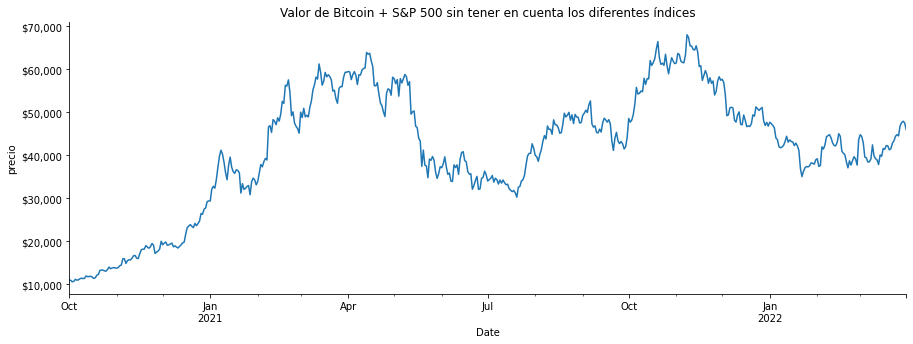

In [49]:
# traza el precio de cierre desde el cuarto trimestre de 2020 hasta el primer trimestre de 2022
ax = portfolio['2020-Q4':'2022-Q1'].plot(
    y='Close', figsize=(15, 5), legend=False,
    title='Valor de Bitcoin + S&P 500 sin tener en cuenta los diferentes índices'
)

# formato
ax.set_ylabel('precio')
ax.yaxis.set_major_formatter(StrMethodFormatter('${x:,.0f}'))
for spine in ['top', 'right']:
    ax.spines[spine].set_visible(False)

# mostrar la grafica
plt.show()

Para solucionarlo, tenemos que alinear el índice del S&P 500 para que coincida con el bitcoin. Utilizaremos el método `reindex()`, pero por defecto obtenemos `NaN` para los valores de los que no tenemos datos:

In [50]:
sp.reindex(bitcoin.index).head(10).assign(
    day_of_week=lambda x: x.index.day_name()
)

,Open,High,Low,Close,Volume,day_of_week
Date,,,,,,
2020-01-01,NaN,NaN,NaN,NaN,NaN,Wednesday
2020-01-02,323.540009,324.890015,322.529999,324.869995,59151200.0,Thursday
2020-01-03,321.160004,323.640015,321.100006,322.410004,77709700.0,Friday
2020-01-04,NaN,NaN,NaN,NaN,NaN,Saturday
2020-01-05,NaN,NaN,NaN,NaN,NaN,Sunday
2020-01-06,320.489990,323.730011,320.359985,323.640015,55653900.0,Monday
2020-01-07,323.019989,323.540009,322.239990,322.730011,40496400.0,Tuesday
2020-01-08,322.940002,325.779999,322.670013,324.450012,68296000.0,Wednesday
2020-01-09,326.160004,326.730011,325.519989,326.649994,48473300.0,Thursday


Así que ahora tenemos filas para cada día del año, pero todos los fines de semana y los días festivos tienen valores `NaN`. Para solucionar esto, podemos especificar cómo manejar los valores que faltan con el argumento `method`. En este caso, queremos rellenar hacia adelante, lo que pondrá los valores de los fines de semana y los días festivos como el valor que tenían para el viernes (o el final de la semana comercial) anterior:

In [51]:
sp.reindex(bitcoin.index, method='ffill').head(10)\
    .assign(day_of_week=lambda x: x.index.day_name())

,Open,High,Low,Close,Volume,day_of_week
Date,,,,,,
2020-01-01,NaN,NaN,NaN,NaN,NaN,Wednesday
2020-01-02,323.540009,324.890015,322.529999,324.869995,59151200.0,Thursday
2020-01-03,321.160004,323.640015,321.100006,322.410004,77709700.0,Friday
2020-01-04,321.160004,323.640015,321.100006,322.410004,77709700.0,Saturday
2020-01-05,321.160004,323.640015,321.100006,322.410004,77709700.0,Sunday
2020-01-06,320.489990,323.730011,320.359985,323.640015,55653900.0,Monday
2020-01-07,323.019989,323.540009,322.239990,322.730011,40496400.0,Tuesday
2020-01-08,322.940002,325.779999,322.670013,324.450012,68296000.0,Wednesday
2020-01-09,326.160004,326.730011,325.519989,326.649994,48473300.0,Thursday


Para aislar los cambios que se producen con el relleno hacia delante, podemos utilizar el método `compare()`. Nos muestra los valores que difieren entre marcos de datos con etiquetas idénticas (mismos nombres y mismas columnas). Aquí, podemos ver que sólo los fines de semana y los días festivos tienen valores rellenados hacia adelante. Observe que los días consecutivos tienen los mismos valores.

In [52]:
sp.reindex(bitcoin.index)\
    .compare(sp.reindex(bitcoin.index, method='ffill'))\
    .head(10).assign(day_of_week=lambda x: x.index.day_name())

Open             High              Low             Close  \
           self       other self       other self       other  self   
Date                                                                  
2020-01-04  NaN  321.160004  NaN  323.640015  NaN  321.100006   NaN   
2020-01-05  NaN  321.160004  NaN  323.640015  NaN  321.100006   NaN   
2020-01-11  NaN  327.290009  NaN  327.459991  NaN  325.200012   NaN   
2020-01-12  NaN  327.290009  NaN  327.459991  NaN  325.200012   NaN   
2020-01-18  NaN  331.700012  NaN  332.179993  NaN  330.850006   NaN   
2020-01-19  NaN  331.700012  NaN  332.179993  NaN  330.850006   NaN   
2020-01-20  NaN  331.700012  NaN  332.179993  NaN  330.850006   NaN   
2020-01-25  NaN  332.440002  NaN  332.529999  NaN  327.359985   NaN   
2020-01-26  NaN  332.440002  NaN  332.529999  NaN  327.359985   NaN   
2020-02-01  NaN  327.000000  NaN  327.170013  NaN  320.730011   NaN   

                       Volume              day_of_week  
                 other   self        other              
Date                                                    
2020-01-04  322.410004    NaN   77709700.0    Saturday  
2020-01-05  322.410004    NaN   77709700.0      Sunday  
2020-01-11  325.709991    NaN   53029300.0    Saturday  
2020-01-12  325.709991    NaN   53029300.0      Sunday  
2020-01-18  331.950012    NaN   95846000.0    Saturday  
2020-01-19  331.950012    NaN   95846000.0      Sunday  
2020-01-20  331.950012    NaN   95846000.0      Monday  
2020-01-25  328.769989    NaN   87578400.0    Saturday  
2020-01-26  328.769989    NaN   87578400.0      Sunday  
2020-02-01  321.730011    NaN  113845600.0    Saturday

Sin embargo, esto no es perfecto. Probablemente queremos 0 para el volumen negociado y poner el precio de cierre para la apertura, el máximo, el mínimo y el cierre en los días en que el mercado está cerrado:

In [53]:
import numpy as np

sp_reindexed = sp.reindex(bitcoin.index).assign(
    volume=lambda x: x.Volume.fillna(0), # poner 0 cuando el mercado está cerrado
    close=lambda x: x.Close.fillna(method='ffill'), # llevar esto adelante
    # tomar el precio de cierre si estos no están disponibles
    open=lambda x: np.where(x.Open.isnull(), x.Close, x.Open),
    high=lambda x: np.where(x.High.isnull(), x.Close, x.High),
    low=lambda x: np.where(x.Low.isnull(), x.Close, x.Low)
)
sp_reindexed.head(10).assign(
    day_of_week=lambda x: x.index.day_name()
)

,Open,High,Low,Close,Volume,volume,close,open,high,low,day_of_week
Date,,,,,,,,,,,
2020-01-01,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,Wednesday
2020-01-02,323.540009,324.890015,322.529999,324.869995,59151200.0,59151200.0,324.869995,323.540009,324.890015,322.529999,Thursday
2020-01-03,321.160004,323.640015,321.100006,322.410004,77709700.0,77709700.0,322.410004,321.160004,323.640015,321.100006,Friday
2020-01-04,NaN,NaN,NaN,NaN,NaN,0.0,322.410004,NaN,NaN,NaN,Saturday
2020-01-05,NaN,NaN,NaN,NaN,NaN,0.0,322.410004,NaN,NaN,NaN,Sunday
2020-01-06,320.489990,323.730011,320.359985,323.640015,55653900.0,55653900.0,323.640015,320.489990,323.730011,320.359985,Monday
2020-01-07,323.019989,323.540009,322.239990,322.730011,40496400.0,40496400.0,322.730011,323.019989,323.540009,322.239990,Tuesday
2020-01-08,322.940002,325.779999,322.670013,324.450012,68296000.0,68296000.0,324.450012,322.940002,325.779999,322.670013,Wednesday
2020-01-09,326.160004,326.730011,325.519989,326.649994,48473300.0,48473300.0,326.649994,326.160004,326.730011,325.519989,Thursday


Si creamos una visualización comparando los datos reindexados con el primer intento, vemos cómo la reindexación ayudó a mantener el valor del activo cuando el mercado estaba cerrado:

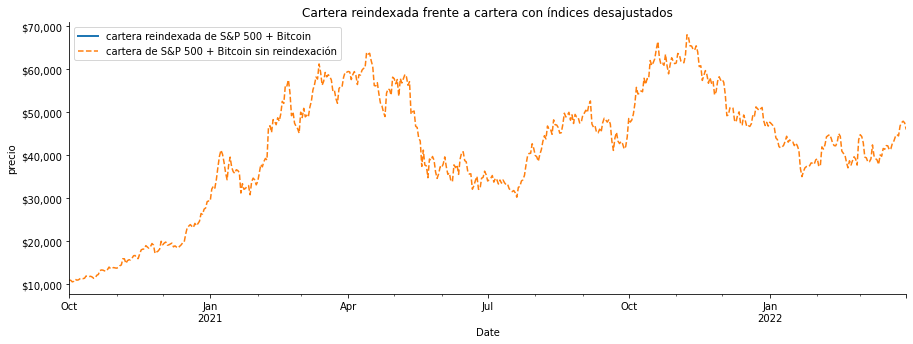

In [54]:
# cada día el precio de cierre = el cierre del S&P 500 ajustado por el cierre del mercado + el cierre del Bitcoin (lo mismo para otras métricas)
fixed_portfolio = sp_reindexed + bitcoin

# trazar el precio de cierre de la cartera reindexada desde el cuarto trimestre de 2020 hasta el primer trimestre de 2022
ax = fixed_portfolio['2020-Q4':'2022-Q1'].plot(
    y='close', label='cartera reindexada de S&P 500 + Bitcoin', figsize=(15, 5), linewidth=2, 
    title='Cartera reindexada frente a cartera con índices desajustados'
)

# añada una línea para la cartera original a modo de comparación
portfolio['2020-Q4':'2022-Q1'].plot(
    y='Close', ax=ax, linestyle='--', label='cartera de S&P 500 + Bitcoin sin reindexación'
)

# formato
ax.set_ylabel('precio')
ax.yaxis.set_major_formatter(StrMethodFormatter('${x:,.0f}'))
for spine in ['top', 'right']:
    ax.spines[spine].set_visible(False)

# mostrar la grafica
plt.show()